In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [155]:
df = pd.read_parquet('./data/yellow_tripdata_2024-01.parquet')

In [156]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [158]:
relevant_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance", "PULocationID", "DOLocationID"]

In [159]:
df = df[relevant_cols]

In [160]:
# df["month"] = df["tpep_pickup_datetime"].dt.month
# df["week"] = df["tpep_pickup_datetime"].dt.isocalendar().week
# df["weekday"] = df["tpep_pickup_datetime"].dt.weekday
# df["hour"] = df["tpep_pickup_datetime"].dt.hour

In [161]:
df["trip_duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60

In [162]:
df = df[(df["trip_duration"] > 0) & (df["trip_duration"] < 60)]

In [163]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID,trip_duration
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.72,186,79,19.800000
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.80,140,236,6.600000
2,2024-01-01 00:17:06,2024-01-01 00:35:01,4.70,236,79,17.916667
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.40,79,211,8.300000
4,2024-01-01 00:46:51,2024-01-01 00:52:57,0.80,211,148,6.100000


In [164]:
df = df.drop(["tpep_pickup_datetime", "tpep_dropoff_datetime"], axis=1)

In [165]:
X = df.drop("trip_duration", axis=1)
y = df["trip_duration"]

In [166]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (2933099, 3)
Shape of y: (2933099,)


In [167]:
num_cols = ["trip_distance"]
cat_cols = ["PULocationID", "DOLocationID"]

In [168]:
X[cat_cols] = X[cat_cols].astype("category")

In [169]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [170]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (2346479, 3)
Shape of X_test: (586620, 3)
Shape of y_train: (2346479,)
Shape of y_test: (586620,)


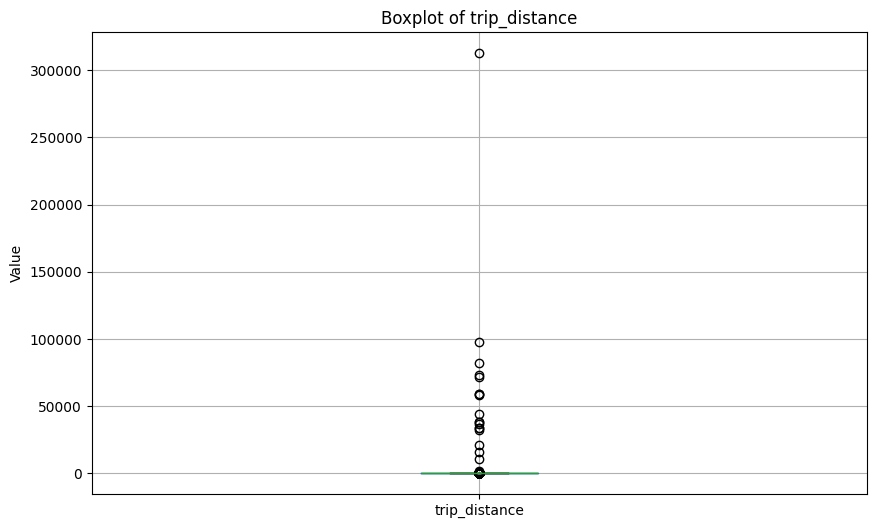

In [171]:
def visualize_outliers(data, column_name):
    plt.figure(figsize=(10, 6))
    data.boxplot(column=[column_name])
    plt.title(f"Boxplot of {column_name}")
    plt.ylabel("Value")
    plt.show()

visualize_outliers(X_train, "trip_distance")

In [172]:
def remove_outlier(data, column_name, threshold=1.5):
    iqr = data[column_name].quantile(0.75) - data[column_name].quantile(0.25)
    lower_bound = data[column_name].quantile(0.25) - (threshold * iqr)
    upper_bound = data[column_name].quantile(0.75) + (threshold * iqr)
    data = data[(data[column_name] > lower_bound) & (data[column_name] < upper_bound)]
    return data

X_train = remove_outlier(X_train, "trip_distance")
y_train = y_train[X_train.index]

In [173]:
X_train.shape

(2056344, 3)

In [174]:
y_train.shape

(2056344,)

In [175]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', TargetEncoder(target_type="continuous"), cat_cols),
        ('scaler', StandardScaler(), num_cols)
    ],
)

In [176]:
X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)

In [177]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train, y_train)

Ridge()

In [178]:
y_pred = model.predict(X_test)

In [179]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

MSE: 154095.08517771808


In [180]:
from lightgbm import LGBMRegressor

model = LGBMRegressor()
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2056344, number of used features: 3
[LightGBM] [Info] Start training from score 11.746494


LGBMRegressor()

In [181]:
from sklearn.metrics import root_mean_squared_error

In [182]:
y_pred = model.predict(X_test)
mse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {mse}")

RMSE: 7.057563567202699


In [195]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {mse}")

RMSE: 6.624691593716032


In [190]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.5, depth=6)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {mse}")

0:	learn: 5.4964968	total: 226ms	remaining: 3m 46s
1:	learn: 4.9163277	total: 421ms	remaining: 3m 30s
2:	learn: 4.7202085	total: 614ms	remaining: 3m 24s
3:	learn: 4.6381171	total: 814ms	remaining: 3m 22s
4:	learn: 4.5921460	total: 1.01s	remaining: 3m 22s
5:	learn: 4.5705930	total: 1.19s	remaining: 3m 16s
6:	learn: 4.5557661	total: 1.41s	remaining: 3m 19s
7:	learn: 4.5378024	total: 1.6s	remaining: 3m 18s
8:	learn: 4.5197544	total: 1.79s	remaining: 3m 17s
9:	learn: 4.5106408	total: 2s	remaining: 3m 17s
10:	learn: 4.4970323	total: 2.29s	remaining: 3m 26s
11:	learn: 4.4904700	total: 2.56s	remaining: 3m 30s
12:	learn: 4.4824464	total: 2.76s	remaining: 3m 29s
13:	learn: 4.4734432	total: 2.99s	remaining: 3m 30s
14:	learn: 4.4695612	total: 3.28s	remaining: 3m 35s
15:	learn: 4.4624725	total: 3.49s	remaining: 3m 34s
16:	learn: 4.4577289	total: 3.67s	remaining: 3m 32s
17:	learn: 4.4526112	total: 3.92s	remaining: 3m 33s
18:	learn: 4.4485760	total: 4.18s	remaining: 3m 35s
19:	learn: 4.4438053	total

## Turn into function

In [220]:
import pandas as pd
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, StandardScaler

In [202]:
def read_dataframe(filename, filetype="parquet"):
    if filetype == "parquet":
        df = pd.read_parquet(filename)
    else:
        df = pd.read_csv(filename)
    
    # Choose relevant columns
    relevant_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance", "PULocationID", "DOLocationID"]
    df = df[relevant_cols]
    
    # Calculate trip duration
    df["trip_duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
    
    # Filter out invalid trip durations
    df = df[(df["trip_duration"] > 0) & (df["trip_duration"] < 60)]
    
    # Drop datetime columns
    df = df.drop(["tpep_pickup_datetime", "tpep_dropoff_datetime"], axis=1)
    
    return df

In [203]:
train_df = read_dataframe('./data/yellow_tripdata_2024-01.parquet')
test_df = read_dataframe('./data/yellow_tripdata_2024-02.parquet')

In [209]:
X_train = train_df.drop("trip_duration", axis=1)
y_train = train_df["trip_duration"]

In [210]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (2933099, 3)
Shape of y_train: (2933099,)


In [211]:
X_test = test_df.drop("trip_duration", axis=1)
y_test = test_df["trip_duration"]

In [212]:
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_test: (2970943, 3)
Shape of y_test: (2970943,)


In [205]:
def remove_outlier(data, column_name, threshold=1.5):
    iqr = data[column_name].quantile(0.75) - data[column_name].quantile(0.25)
    lower_bound = data[column_name].quantile(0.25) - (threshold * iqr)
    upper_bound = data[column_name].quantile(0.75) + (threshold * iqr)
    data = data[(data[column_name] > lower_bound) & (data[column_name] < upper_bound)]
    return data

In [216]:
def preprocessing(X, y, return_preprocessor=False, preprocessor=None):
    X = remove_outlier(X, "trip_distance")
    y = y[X.index]
    
    num_cols = ["trip_distance"]
    cat_cols = ["PULocationID", "DOLocationID"]
    
    if not preprocessor:
        preprocessor = ColumnTransformer(
            transformers=[
                ('encoder', TargetEncoder(target_type="continuous"), cat_cols),
                ('scaler', StandardScaler(), num_cols)
            ],
        )
    
    X = preprocessor.fit_transform(X, y)
    
    if return_preprocessor and not preprocessor:
        return X, y, preprocessor
    return X, y

In [214]:
X_train, y_train, preprocessor = preprocessing(X_train, y_train, return_preprocessor=True)

In [217]:
X_test, y_test = preprocessing(X_test, y_test, preprocessor=preprocessor)

In [218]:
def train(X, y, model):
    model.fit(X, y)
    return model

def evaluate(X, y, model):
    y_pred = model.predict(X)
    mse = root_mean_squared_error(y, y_pred)
    return mse

In [219]:
xgb_model = XGBRegressor()
xgb_model = train(X_train, y_train, xgb_model)
xgb_mse = evaluate(X_test, y_test, xgb_model)
print(f"XGBoost RMSE: {xgb_mse}")

XGBoost RMSE: 5.109261136640832


In [223]:
with open('model/model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)